# Section 4.3.2

This is an implementation of the second order problem in Sec. 4.3.2 of the paper

    M Mortensen, "A generic and strictly banded spectral Petrov-Galerkin method for differential equations with polynomial coefficients"
    

# Helmholtz equation

The Helmholtz Dirichlet problem is described as

$$
u''(x) - \mu u(x) = f(x), \quad u(\pm 1) = 0,  x \in [-1, 1]
$$

where $\mu \ge 0$ is a constant, $f(x)$ is some right hand side function and $u(x)$ is the solution. For the solution we will use either one of the orthogonal polynomials $Q_n(x)$ defined in [Section-4.3.1](Section-4.3.1.ipynb). That is, we use $T_n, L_n, U_n$ or $Q^{(\alpha)}_n$.

We solve the Helmholtz equation with a Petrov-Galerkin method and use the trial functions 

$$
\psi_n = Q_n-Q_{n+2}, \quad n=0,1, \ldots, N-2,
$$

for the three families $Q_n=T_n, L_n,$ or $Q^{(\alpha)}_n$. For Chebyshev polynomials of the second kind the trial functions are

$$
\psi_n = {U_n}-\frac{n+1}{n+3}U_{n+2}, \quad n=0,1, \ldots, N-2
$$

which is actually equal to $\psi_n=(n+1)(Q^{(1/2)}_n-Q^{(1/2)}_{n+2})$.

The trial space is $S=\{\psi_n\}_{n=0}^{N-2}$. For the test space we use $V=\text{span}\left\{\phi^{(2)}_n\right\}_{n=0}^{N-2}$, where $\phi^{(2)}_n$ also was defined in [Section-4.3.1](Section-4.3.1.ipynb). Note that we use

$$
\phi^{(k)}_n = \frac{(1-x^2)^k}{h^{(k)}_{n+k}} \frac{d^k Q_{n+k}}{dx^k},
$$

for $Q_n=T_n, L_n, Q^{(\alpha)}_n$, or $U_n$, and that $h^{(k)}_{n+k}$ includes the scaling function $g_n$.

The method is to find $u \in S$ such that

$$
(u'', v)_{\omega^{\alpha}} - \mu(u, v)_{\omega^{\alpha}} = (f, v)_{\omega^{\alpha}}, \quad \text{for all } v \in V
$$

We start by importing shenfun's functionality, and specify some parameters with obvious meaning.

In [1]:
from shenfun import *
import matplotlib.pyplot as plt

N = 60
mu = 1

Choose family of polynomials by uncommenting only one of the following four lines.

In [2]:
#family = 'Ultraspherical'; kw = {'alpha': 1}
#family = 'Legendre'; kw = {}
family = 'Chebyshev'; kw = {}
#family = 'ChebyshevU'; kw = {}

Create function spaces and test and trial functions. Assemble the coefficient matrix A, that will consist of both mass and stiffness matrices.

In [3]:
S = FunctionSpace(N, family, bc=(0, 0), **kw)
V = FunctionSpace(N+2, family, basis='Phi2', **kw)
u = TrialFunction(S)
v = TestFunction(V)
A = inner(v, div(grad(u)) - mu*u)

Text(0.5, 0.98, 'Sparsity pattern stiffness (left) and mass (right) matrix')

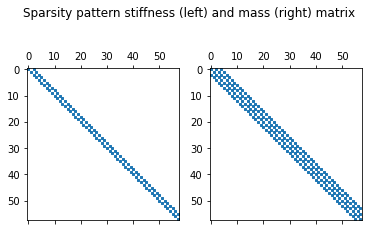

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(A[0].diags(), ms=2)
ax2.spy(A[1].diags(), ms=2)
fig.suptitle('Sparsity pattern stiffness (left) and mass (right) matrix')

## Alternative formulation

An alternative formulation (see Sec. 4.1.4) for this problem  is to find $u\in \text{V}^{(1)}_N$ such that 

\begin{equation}
    (u'', v)_{\omega^{(\alpha+1)}} - \mu (u, v)_{\omega^{(\alpha+1)}} = (f, v)_{\omega^{(\alpha+1)}}, \quad \forall \, v \in \text{V}^{(1)}_{N} = \text{span}\{\overline{\phi}^{(2,\alpha)}_m\}_{m=0}^{N-2},
\end{equation}

where 

\begin{equation}
    \overline{\phi}^{(2,\alpha,\beta)}_m = \gamma^{(2,\alpha,\beta)}_{m} \phi^{(1, \alpha+1, \beta+1)}_{m}, \label{eq:phiover}
\end{equation}

and $\gamma^{(2,\alpha,\beta)}_m$ is given by Eq. (4.18) in the paper.

We use Chebyshev polynomials of the first kind for trial function ($\psi_n=T_n-T_{n+2}$) and the second kind for the test functions that become 

$$
\overline{\phi}^{(2,-1/2, -1/2)}_m = \frac{1}{m+2} \phi^{(1,1/2,1/2)}_m =  \frac{1}{\pi (m+2)}\left(\frac{U_m}{m+1}-\frac{U_{m+2}}{m+3}\right)
$$

It is implemented in shenfun as

In [5]:
S = FunctionSpace(N, 'C', bc=(0, 0))
V = FunctionSpace(N, 'U', basis='Phi1', scaled=True)
u = TrialFunction(S)
v = TestFunction(V)
A2 = inner(v, div(grad(u)) - mu*u)

Verify that the matrix is the same as `A` assembled above. Need to make sure Chebyshev is used, so recompute `A` here

In [6]:
S = FunctionSpace(N, 'C', bc=(0, 0), **kw)
V = FunctionSpace(N+2, 'C', basis='Phi2', **kw)
u = TrialFunction(S)
v = TestFunction(V)
A = inner(v, div(grad(u)) - mu*u)

In [7]:
M = A[0].diags('csr') + A[1].diags('csr')
M2 = A2[0].diags('csr') + A2[1].diags('csr')
assert np.linalg.norm((M-M2).toarray()) < 1e-14

If the assert passes, then the matrices are the same.

# Condition numbers

Check the condition number of the coefficient matrix. Use a relatively low number since Jacobi is not implemented very robustly, with gamma functions that overflow. Also, Numpy's routine for computing the condition number makes use of dense matrices, which limits the size. 

In [8]:
def cond(N, family='Chebyshev', alpha=0):
    """Return condition number of Helmholtz coefficient matrix
    
    Parameters
    ----------
    N : int
        The number of quadrature points. For a Dirichlet space there is N-2 dofs.
    family : str, optional
        Either one of
        - 'Chebyshev'      (or 'C')
        - 'ChebyshevU'     (or 'U') 
        - 'Legendre'       (or 'L')
        - 'Ultraspherical' (or 'Q')
    alpha : number, optional
        Parameters used only by the Ultraspherical family
    """
    assert N < 1000
    S = FunctionSpace(N, family, bc=(0, 0), alpha=alpha)
    V = FunctionSpace(N+2, family, basis='Phi2', alpha=alpha)
    u = TrialFunction(S)
    v = TestFunction(V)
    A = inner(v, div(grad(u)) - mu*u)
    M = np.sum(np.array(A, dtype=object)).diags()
    return np.linalg.cond(M.toarray())

Run over all families and compute the condition numbers for a range of matrix sizes.

In [9]:
alpha = 0.5
con = {'C': [], 'L': [], 'U': [], 'Q': []}
for family in 'CULQ':
    for n in range(3, 8):
        con[family].append(cond(2**n, family, alpha)) # alpha neglected by C, U, L

Plot the condition numbers using loglog axes to show that Chebyshev, Legendre and any ultraspherical basis using scaling $g_n^{\alpha}=(P^{(\alpha,\alpha)}_n(1))^{-1}$ obtain condition numbers that are $\mathcal{O}(N)$, whereas Chebyshev of the second kind (which uses a slightly different scaling) obtain condition numbers scaling as $\mathcal{O}(N^{3/2})$. Note that an ultraspherical basis with $\alpha=1/2$ results in $\mathcal{O}(N)$. 

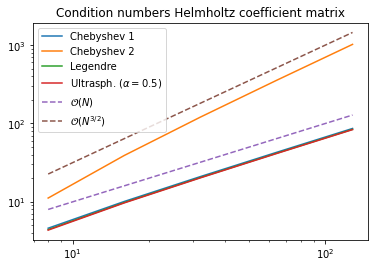

In [10]:
for family in 'CULQ':
    plt.loglog(2**np.array(range(3, 8)), con[family])

plt.loglog(2**np.array(range(3, 8)), 2**np.array(range(3, 8)), '--')
plt.loglog(2**np.array(range(3, 8)), (2**np.array(range(3, 8)))**1.5, '--')
plt.legend(['Chebyshev 1', 'Chebyshev 2', 'Legendre', rf'Ultrasph. $(\alpha={alpha})$', r'$\mathcal{O}(N)$', r'$\mathcal{O}(N^{3/2})$'])
plt.title('Condition numbers Helmholtz coefficient matrix')
plt.show()

# The Airy equation 

Another second order problem is the Airy differential equation

\begin{equation}
    \epsilon u'' - x u = 0, \quad u(-1) = \text{Ai}\left(-\sqrt[3]{\tfrac{1}{\epsilon}}\right), u(1) = \text{Ai}\left(\sqrt[3]{\tfrac{1}{\epsilon}}\right), \label{eq:airy}
\end{equation}

which has the Airy function $u(x) = \text{Ai}\left(\sqrt[3]{\tfrac{1}{\epsilon}} x\right)$ as solution.

In [11]:
import sympy as sp
x = sp.Symbol('x', real=True)

#e = sp.Rational(1, 1e9)
e = sp.Rational(1, 1e6)
ue = sp.airyai((1/e)**(sp.Rational(1, 3))*x)

def main(N, family, alpha=0, returnmat=False):
    SN = FunctionSpace(N, family, bc=(ue.subs(x, -1), ue.subs(x, 1)))
    VN = FunctionSpace(N+2, family, basis='Phi2')
    u = TrialFunction(SN)
    v = TestFunction(VN)
    A = [inner(div(grad(u)), e*v)] + inner(u, -x*v)
    sol = la.Solver(A)
    if returnmat:
        return sol.mat
    u_hat = Function(SN)
    f_hat = Function(SN)
    u_hat = sol(f_hat, u_hat)
    ua = Array(SN.get_orthogonal(), buffer=ue)
    return np.sqrt(inner(1, (u_hat.backward()-ua)**2))


In [12]:
error = []
M = np.arange(500, 900, 10)
#M = np.hstack([np.arange(200, 19201, 1000), np.arange(19220, 20781, 20), np.arange(20800, 40000, 1000)])
for N in M:
    error.append(main(N, 'C'))

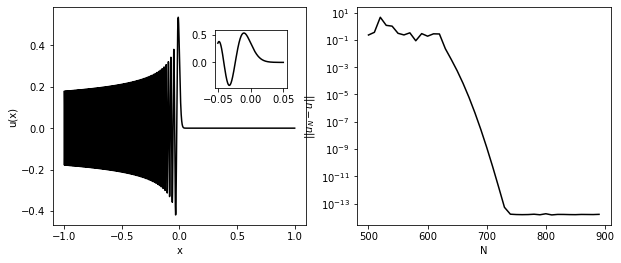

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].semilogy(M, error, 'k')
ax[1].set(xlabel='N', ylabel='$||u_N-u||$')
M = np.linspace(-1, 1, 40000)
ax[0].plot(M, sp.lambdify(x, ue)(M), 'k')
ax[0].set(xlabel='x', ylabel='u(x)')
left, bottom, width, height = [0.35, 0.6, 0.1, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
M = np.linspace(-0.05, 0.05, 1000)
ax2.plot(M, sp.lambdify(x, ue)(M), 'k')
plt.show()